# Prediction of Graphical Data for different types of EEG graph, which is a time based Graphical interface and getting the future prediction for seizure and non-seizure values, as we move through the time.

In [ ]:
!pip install mne

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 19.0 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import mne
import os
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import ShuffleSplit, cross_val_score

from mne import Epochs, pick_types, events_from_annotations
from mne.channels import make_standard_montage
from mne.io import concatenate_raws, read_raw_edf
from mne.datasets import eegbci
from mne.decoding import CSP
from mne.preprocessing import ICA, create_eog_epochs, create_ecg_epochs
from time import time
import pandas as pd

In [ ]:
def power_spectral(fmin, fmax, n_fft, raw, info):
    raw.plot_psd(fmin=fmin, fmax=fmax, n_fft=n_fft)
    plt.show()


In [ ]:

raw  = mne.io.read_raw_edf("/content/drive/MyDrive/Masum_Thesis_1/chb01_01.edf")
raw.load_data()

Extracting EDF parameters from /content/drive/MyDrive/Masum_Thesis_1/chb01_01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-5-b4af02c23856>:1: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw  = mne.io.read_raw_edf("/content/drive/MyDrive/Masum_Thesis_1/chb01_01.edf")


Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


<RawEDF | chb01_01.edf, 23 x 921600 (3600.0 s), ~161.7 MB, data loaded>

In [ ]:
info = raw.info

In [ ]:
info

<Info | 8 non-empty values
 bads: []
 ch_names: FP1-F7, F7-T7, T7-P7, P7-O1, FP1-F3, F3-C3, C3-P3, P3-O1, ...
 chs: 23 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 128.0 Hz
 meas_date: 2076-11-06 11:42:54 UTC
 nchan: 23
 projs: []
 sfreq: 256.0 Hz
 subject_info: 1 item (dict)
>

In [ ]:
print(info['sfreq'], 'Hz')
print(info['chs'])

256.0 Hz
[{'cal': 1.0, 'logno': 1, 'scanno': 1, 'range': 1.0, 'unit_mul': 0 (FIFF_UNITM_NONE), 'ch_name': 'FP1-F7', 'unit': 107 (FIFF_UNIT_V), 'coord_frame': 4 (FIFFV_COORD_HEAD), 'coil_type': 1 (FIFFV_COIL_EEG), 'kind': 2 (FIFFV_EEG_CH), 'loc': array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])}, {'cal': 1.0, 'logno': 2, 'scanno': 2, 'range': 1.0, 'unit_mul': 0 (FIFF_UNITM_NONE), 'ch_name': 'F7-T7', 'unit': 107 (FIFF_UNIT_V), 'coord_frame': 4 (FIFFV_COORD_HEAD), 'coil_type': 1 (FIFFV_COIL_EEG), 'kind': 2 (FIFFV_EEG_CH), 'loc': array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])}, {'cal': 1.0, 'logno': 3, 'scanno': 3, 'range': 1.0, 'unit_mul': 0 (FIFF_UNITM_NONE), 'ch_name': 'T7-P7', 'unit': 107 (FIFF_UNIT_V), 'coord_frame': 4 (FIFFV_COORD_HEAD), 'coil_type': 1 (FIFFV_COIL_EEG), 'kind': 2 (FIFFV_EEG_CH), 'loc': array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])}, {'cal': 1.0, 'logno': 4, 'scanno': 4, 'range': 1.0, 'unit_mul': 0 (FIFF_UN

In [ ]:
info['chs']

[{'cal': 1.0,
  'logno': 1,
  'scanno': 1,
  'range': 1.0,
  'unit_mul': 0 (FIFF_UNITM_NONE),
  'ch_name': 'FP1-F7',
  'unit': 107 (FIFF_UNIT_V),
  'coord_frame': 4 (FIFFV_COORD_HEAD),
  'coil_type': 1 (FIFFV_COIL_EEG),
  'kind': 2 (FIFFV_EEG_CH),
  'loc': array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])},
 {'cal': 1.0,
  'logno': 2,
  'scanno': 2,
  'range': 1.0,
  'unit_mul': 0 (FIFF_UNITM_NONE),
  'ch_name': 'F7-T7',
  'unit': 107 (FIFF_UNIT_V),
  'coord_frame': 4 (FIFFV_COORD_HEAD),
  'coil_type': 1 (FIFFV_COIL_EEG),
  'kind': 2 (FIFFV_EEG_CH),
  'loc': array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])},
 {'cal': 1.0,
  'logno': 3,
  'scanno': 3,
  'range': 1.0,
  'unit_mul': 0 (FIFF_UNITM_NONE),
  'ch_name': 'T7-P7',
  'unit': 107 (FIFF_UNIT_V),
  'coord_frame': 4 (FIFFV_COORD_HEAD),
  'coil_type': 1 (FIFFV_COIL_EEG),
  'kind': 2 (FIFFV_EEG_CH),
  'loc': array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])},
 {'cal': 1.0,
  'logn

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.1s


Using matplotlib as 2D backend.


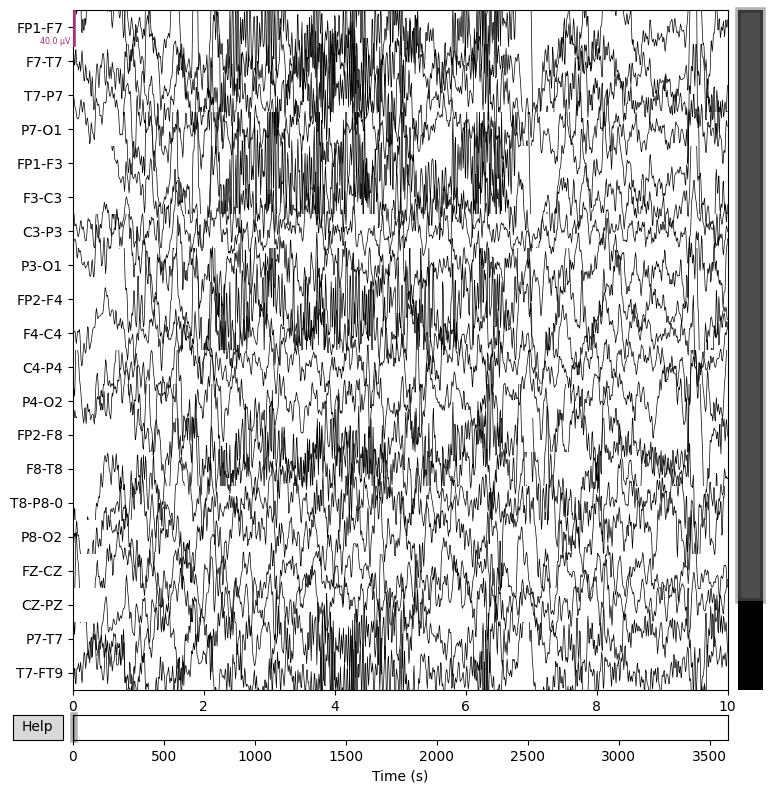

In [ ]:
raw.filter(0.5, 30)
raw.plot()
plt.show()

In [ ]:
raw_data, time = raw[:, :]

In [ ]:
len(raw_data)

23

In [ ]:
print(time.shape)

(921600,)


In [ ]:
raw_data

array([[ 2.20228566e-20,  7.24269502e-05,  1.29094369e-04, ...,
        -1.90085700e-05, -1.22452000e-05,  1.69406589e-21],
       [ 2.79520873e-20,  4.86919890e-05,  8.76270207e-05, ...,
        -9.11215763e-06, -4.61448859e-06, -5.08219768e-21],
       [-6.77626358e-21,  2.38920647e-05,  4.17985427e-05, ...,
         1.53071497e-05,  9.25901415e-06, -7.19978005e-21],
       ...,
       [ 5.75982404e-20,  1.28902382e-04,  2.30908052e-04, ...,
         4.98778428e-05,  2.94600418e-05, -1.01643954e-20],
       [-1.27054942e-20, -4.70185174e-05, -8.38591404e-05, ...,
         1.29704321e-05,  7.20974703e-06,  3.38813179e-21],
       [-1.01643954e-20, -2.33846993e-05, -4.11413860e-05, ...,
        -7.16156787e-06, -4.29069520e-06, -1.69406589e-21]])

In [ ]:
a = raw_data[:, 0]

In [ ]:
len(raw_data[0,:])

921600

In [ ]:
b = raw_data[0, :]
b

array([ 2.20228566e-20,  7.24269502e-05,  1.29094369e-04, ...,
       -1.90085700e-05, -1.22452000e-05,  1.69406589e-21])

In [ ]:
df = pd.DataFrame(raw_data)

In [ ]:
df

,0,1,2,3,4,5,6,7,8,9,...,921590,921591,921592,921593,921594,921595,921596,921597,921598,921599
0,2.202286e-20,0.000072,0.000129,0.000161,0.000167,1.564453e-04,0.000141,0.000131,0.000131,0.000137,...,0.000012,2.060566e-05,2.291559e-05,1.732316e-05,5.617577e-06,-7.722867e-06,-0.000017,-0.000019,-1.224520e-05,1.694066e-21
1,2.795209e-20,0.000049,0.000088,0.000111,0.000118,1.146204e-04,0.000106,0.000099,0.000093,0.000089,...,-0.000012,-1.346663e-05,-1.564704e-05,-1.735990e-05,-1.767453e-05,-1.620562e-05,-0.000013,-0.000009,-4.614489e-06,-5.082198e-21
2,-6.776264e-21,0.000024,0.000042,0.000050,0.000050,4.353408e-05,0.000037,0.000035,0.000038,0.000045,...,-0.000004,-4.158471e-06,-3.157187e-06,5.212091e-07,6.487398e-06,1.269131e-05,0.000016,0.000015,9.259014e-06,-7.199780e-21
3,6.776264e-21,0.000016,0.000028,0.000036,0.000038,3.672869e-05,0.000033,0.000030,0.000027,0.000026,...,0.000026,2.633257e-05,2.833793e-05,2.994592e-05,2.940373e-05,2.598918e-05,0.000020,0.000013,6.548484e-06,3.388132e-21
4,2.625802e-20,0.000084,0.000150,0.000187,0.000195,1.833958e-04,0.000167,0.000155,0.000153,0.000157,...,0.000028,3.384556e-05,3.189389e-05,2.133496e-05,4.850406e-06,-1.210515e-05,-0.000023,-0.000025,-1.560064e-05,1.694066e-20
5,3.218725e-20,0.000055,0.000099,0.000122,0.000127,1.184634e-04,0.000107,0.000099,0.000098,0.000103,...,-0.000027,-2.659751e-05,-2.713858e-05,-2.873835e-05,-3.036598e-05,-3.047196e-05,-0.000028,-0.000021,-1.156246e-05,-1.778769e-20
6,-9.317362e-21,-0.000006,-0.000010,-0.000013,-0.000013,-1.274855e-05,-0.000012,-0.000011,-0.000011,-0.000011,...,-0.000002,-6.579083e-06,-7.789574e-06,-4.287265e-06,3.274667e-06,1.193232e-05,0.000018,0.000018,1.088816e-05,-8.893846e-21
7,8.470329e-21,0.000027,0.000048,0.000061,0.000065,6.235454e-05,0.000057,0.000052,0.000049,0.000049,...,0.000022,2.760029e-05,3.451232e-05,4.130249e-05,4.542128e-05,4.488022e-05,0.000039,0.000029,1.506543e-05,-3.388132e-21
8,2.879912e-20,0.000069,0.000124,0.000155,0.000161,1.500130e-04,0.000134,0.000122,0.000122,0.000130,...,-0.000002,1.067961e-05,1.949764e-05,2.115574e-05,1.525521e-05,4.971613e-06,-0.000005,-0.000009,-6.778024e-06,-3.388132e-21
9,0.000000e+00,0.000001,0.000002,0.000002,0.000001,8.152416e-07,0.000001,0.000002,0.000002,0.000002,...,0.000005,6.055720e-06,5.285624e-06,3.291590e-06,1.083709e-06,-5.872248e-07,-0.000001,-0.000001,-8.355609e-07,8.470329e-22


In [ ]:
df[1]

0     0.000072
1     0.000049
2     0.000024
3     0.000016
4     0.000084
5     0.000055
6    -0.000006
7     0.000027
8     0.000069
9     0.000001
10   -0.000031
11    0.000011
12    0.000135
13   -0.000030
14   -0.000023
15   -0.000031
16    0.000052
17   -0.000042
18   -0.000024
19    0.000033
20    0.000129
21   -0.000047
22   -0.000023
Name: 1, dtype: float64

In [ ]:
import glob
a = glob.glob("/content/drive/MyDrive/Masum_Thesis_1/*.edf")

In [ ]:
#So we take only one graph or time series for further evaluation which is FP1-F7
raw_data_1 = []
for i in range(20):
  raw_d = mne.io.read_raw_edf(a[i])
  raw_d.load_data()
  raw_data, time = raw[:, :]
  raw_data_1.append(raw_data[0, :])

Extracting EDF parameters from /content/drive/MyDrive/Masum_Thesis_1/chb01_04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


<ipython-input-22-252b75b34ded>:4: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw_d = mne.io.read_raw_edf(a[i])


Extracting EDF parameters from /content/drive/MyDrive/Masum_Thesis_1/chb01_15.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


<ipython-input-22-252b75b34ded>:4: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw_d = mne.io.read_raw_edf(a[i])


Extracting EDF parameters from /content/drive/MyDrive/Masum_Thesis_1/chb01_06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


<ipython-input-22-252b75b34ded>:4: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw_d = mne.io.read_raw_edf(a[i])


Extracting EDF parameters from /content/drive/MyDrive/Masum_Thesis_1/chb01_13.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


<ipython-input-22-252b75b34ded>:4: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw_d = mne.io.read_raw_edf(a[i])


Extracting EDF parameters from /content/drive/MyDrive/Masum_Thesis_1/chb01_12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


<ipython-input-22-252b75b34ded>:4: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw_d = mne.io.read_raw_edf(a[i])


Extracting EDF parameters from /content/drive/MyDrive/Masum_Thesis_1/chb01_20.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 681727  =      0.000 ...  2662.996 secs...


<ipython-input-22-252b75b34ded>:4: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw_d = mne.io.read_raw_edf(a[i])


Extracting EDF parameters from /content/drive/MyDrive/Masum_Thesis_1/chb01_07.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


<ipython-input-22-252b75b34ded>:4: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw_d = mne.io.read_raw_edf(a[i])


Extracting EDF parameters from /content/drive/MyDrive/Masum_Thesis_1/chb01_18.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


<ipython-input-22-252b75b34ded>:4: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw_d = mne.io.read_raw_edf(a[i])


Extracting EDF parameters from /content/drive/MyDrive/Masum_Thesis_1/chb01_10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


<ipython-input-22-252b75b34ded>:4: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw_d = mne.io.read_raw_edf(a[i])


Extracting EDF parameters from /content/drive/MyDrive/Masum_Thesis_1/chb01_02.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


<ipython-input-22-252b75b34ded>:4: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw_d = mne.io.read_raw_edf(a[i])


Extracting EDF parameters from /content/drive/MyDrive/Masum_Thesis_1/chb01_01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


<ipython-input-22-252b75b34ded>:4: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw_d = mne.io.read_raw_edf(a[i])


Extracting EDF parameters from /content/drive/MyDrive/Masum_Thesis_1/chb01_14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


<ipython-input-22-252b75b34ded>:4: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw_d = mne.io.read_raw_edf(a[i])


Extracting EDF parameters from /content/drive/MyDrive/Masum_Thesis_1/chb01_16.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


<ipython-input-22-252b75b34ded>:4: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw_d = mne.io.read_raw_edf(a[i])


Extracting EDF parameters from /content/drive/MyDrive/Masum_Thesis_1/chb01_17.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


<ipython-input-22-252b75b34ded>:4: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw_d = mne.io.read_raw_edf(a[i])


Extracting EDF parameters from /content/drive/MyDrive/Masum_Thesis_1/chb01_11.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


<ipython-input-22-252b75b34ded>:4: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw_d = mne.io.read_raw_edf(a[i])


Extracting EDF parameters from /content/drive/MyDrive/Masum_Thesis_1/chb01_09.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


<ipython-input-22-252b75b34ded>:4: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw_d = mne.io.read_raw_edf(a[i])


Extracting EDF parameters from /content/drive/MyDrive/Masum_Thesis_1/chb01_03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


<ipython-input-22-252b75b34ded>:4: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw_d = mne.io.read_raw_edf(a[i])


Extracting EDF parameters from /content/drive/MyDrive/Masum_Thesis_1/chb01_08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


<ipython-input-22-252b75b34ded>:4: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw_d = mne.io.read_raw_edf(a[i])


Extracting EDF parameters from /content/drive/MyDrive/Masum_Thesis_1/chb01_19.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


<ipython-input-22-252b75b34ded>:4: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw_d = mne.io.read_raw_edf(a[i])


Extracting EDF parameters from /content/drive/MyDrive/Masum_Thesis_1/chb01_05.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


<ipython-input-22-252b75b34ded>:4: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw_d = mne.io.read_raw_edf(a[i])


In [ ]:
df = pd.DataFrame(raw_data_1)

In [ ]:
df

,0,1,2,3,4,5,6,7,8,9,...,921590,921591,921592,921593,921594,921595,921596,921597,921598,921599
0,2.202286e-20,0.000072,0.000129,0.000161,0.000167,0.000156,0.000141,0.000131,0.000131,0.000137,...,0.000012,0.000021,0.000023,0.000017,0.000006,-0.000008,-0.000017,-0.000019,-0.000012,1.694066e-21
1,2.202286e-20,0.000072,0.000129,0.000161,0.000167,0.000156,0.000141,0.000131,0.000131,0.000137,...,0.000012,0.000021,0.000023,0.000017,0.000006,-0.000008,-0.000017,-0.000019,-0.000012,1.694066e-21
2,2.202286e-20,0.000072,0.000129,0.000161,0.000167,0.000156,0.000141,0.000131,0.000131,0.000137,...,0.000012,0.000021,0.000023,0.000017,0.000006,-0.000008,-0.000017,-0.000019,-0.000012,1.694066e-21
3,2.202286e-20,0.000072,0.000129,0.000161,0.000167,0.000156,0.000141,0.000131,0.000131,0.000137,...,0.000012,0.000021,0.000023,0.000017,0.000006,-0.000008,-0.000017,-0.000019,-0.000012,1.694066e-21
4,2.202286e-20,0.000072,0.000129,0.000161,0.000167,0.000156,0.000141,0.000131,0.000131,0.000137,...,0.000012,0.000021,0.000023,0.000017,0.000006,-0.000008,-0.000017,-0.000019,-0.000012,1.694066e-21
5,2.202286e-20,0.000072,0.000129,0.000161,0.000167,0.000156,0.000141,0.000131,0.000131,0.000137,...,0.000012,0.000021,0.000023,0.000017,0.000006,-0.000008,-0.000017,-0.000019,-0.000012,1.694066e-21
6,2.202286e-20,0.000072,0.000129,0.000161,0.000167,0.000156,0.000141,0.000131,0.000131,0.000137,...,0.000012,0.000021,0.000023,0.000017,0.000006,-0.000008,-0.000017,-0.000019,-0.000012,1.694066e-21
7,2.202286e-20,0.000072,0.000129,0.000161,0.000167,0.000156,0.000141,0.000131,0.000131,0.000137,...,0.000012,0.000021,0.000023,0.000017,0.000006,-0.000008,-0.000017,-0.000019,-0.000012,1.694066e-21
8,2.202286e-20,0.000072,0.000129,0.000161,0.000167,0.000156,0.000141,0.000131,0.000131,0.000137,...,0.000012,0.000021,0.000023,0.000017,0.000006,-0.000008,-0.000017,-0.000019,-0.000012,1.694066e-21
9,2.202286e-20,0.000072,0.000129,0.000161,0.000167,0.000156,0.000141,0.000131,0.000131,0.000137,...,0.000012,0.000021,0.000023,0.000017,0.000006,-0.000008,-0.000017,-0.000019,-0.000012,1.694066e-21


In [ ]:
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM, Flatten, Activation, Dropout
import seaborn as sns

In [ ]:
df_1 = df.T

In [ ]:
df_1

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,2.202286e-20,2.202286e-20,2.202286e-20,2.202286e-20,2.202286e-20,2.202286e-20,2.202286e-20,2.202286e-20,2.202286e-20,2.202286e-20,2.202286e-20,2.202286e-20,2.202286e-20,2.202286e-20,2.202286e-20,2.202286e-20,2.202286e-20,2.202286e-20,2.202286e-20,2.202286e-20
1,7.242695e-05,7.242695e-05,7.242695e-05,7.242695e-05,7.242695e-05,7.242695e-05,7.242695e-05,7.242695e-05,7.242695e-05,7.242695e-05,7.242695e-05,7.242695e-05,7.242695e-05,7.242695e-05,7.242695e-05,7.242695e-05,7.242695e-05,7.242695e-05,7.242695e-05,7.242695e-05
2,1.290944e-04,1.290944e-04,1.290944e-04,1.290944e-04,1.290944e-04,1.290944e-04,1.290944e-04,1.290944e-04,1.290944e-04,1.290944e-04,1.290944e-04,1.290944e-04,1.290944e-04,1.290944e-04,1.290944e-04,1.290944e-04,1.290944e-04,1.290944e-04,1.290944e-04,1.290944e-04
3,1.605383e-04,1.605383e-04,1.605383e-04,1.605383e-04,1.605383e-04,1.605383e-04,1.605383e-04,1.605383e-04,1.605383e-04,1.605383e-04,1.605383e-04,1.605383e-04,1.605383e-04,1.605383e-04,1.605383e-04,1.605383e-04,1.605383e-04,1.605383e-04,1.605383e-04,1.605383e-04
4,1.668447e-04,1.668447e-04,1.668447e-04,1.668447e-04,1.668447e-04,1.668447e-04,1.668447e-04,1.668447e-04,1.668447e-04,1.668447e-04,1.668447e-04,1.668447e-04,1.668447e-04,1.668447e-04,1.668447e-04,1.668447e-04,1.668447e-04,1.668447e-04,1.668447e-04,1.668447e-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
921595,-7.722867e-06,-7.722867e-06,-7.722867e-06,-7.722867e-06,-7.722867e-06,-7.722867e-06,-7.722867e-06,-7.722867e-06,-7.722867e-06,-7.722867e-06,-7.722867e-06,-7.722867e-06,-7.722867e-06,-7.722867e-06,-7.722867e-06,-7.722867e-06,-7.722867e-06,-7.722867e-06,-7.722867e-06,-7.722867e-06
921596,-1.726494e-05,-1.726494e-05,-1.726494e-05,-1.726494e-05,-1.726494e-05,-1.726494e-05,-1.726494e-05,-1.726494e-05,-1.726494e-05,-1.726494e-05,-1.726494e-05,-1.726494e-05,-1.726494e-05,-1.726494e-05,-1.726494e-05,-1.726494e-05,-1.726494e-05,-1.726494e-05,-1.726494e-05,-1.726494e-05
921597,-1.900857e-05,-1.900857e-05,-1.900857e-05,-1.900857e-05,-1.900857e-05,-1.900857e-05,-1.900857e-05,-1.900857e-05,-1.900857e-05,-1.900857e-05,-1.900857e-05,-1.900857e-05,-1.900857e-05,-1.900857e-05,-1.900857e-05,-1.900857e-05,-1.900857e-05,-1.900857e-05,-1.900857e-05,-1.900857e-05
921598,-1.224520e-05,-1.224520e-05,-1.224520e-05,-1.224520e-05,-1.224520e-05,-1.224520e-05,-1.224520e-05,-1.224520e-05,-1.224520e-05,-1.224520e-05,-1.224520e-05,-1.224520e-05,-1.224520e-05,-1.224520e-05,-1.224520e-05,-1.224520e-05,-1.224520e-05,-1.224520e-05,-1.224520e-05,-1.224520e-05


In [ ]:
#We take only 1000000 time series for further analysis
df_2 = df_1[:100000]

In [ ]:
df_2

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,2.202286e-20,2.202286e-20,2.202286e-20,2.202286e-20,2.202286e-20,2.202286e-20,2.202286e-20,2.202286e-20,2.202286e-20,2.202286e-20,2.202286e-20,2.202286e-20,2.202286e-20,2.202286e-20,2.202286e-20,2.202286e-20,2.202286e-20,2.202286e-20,2.202286e-20,2.202286e-20
1,7.242695e-05,7.242695e-05,7.242695e-05,7.242695e-05,7.242695e-05,7.242695e-05,7.242695e-05,7.242695e-05,7.242695e-05,7.242695e-05,7.242695e-05,7.242695e-05,7.242695e-05,7.242695e-05,7.242695e-05,7.242695e-05,7.242695e-05,7.242695e-05,7.242695e-05,7.242695e-05
2,1.290944e-04,1.290944e-04,1.290944e-04,1.290944e-04,1.290944e-04,1.290944e-04,1.290944e-04,1.290944e-04,1.290944e-04,1.290944e-04,1.290944e-04,1.290944e-04,1.290944e-04,1.290944e-04,1.290944e-04,1.290944e-04,1.290944e-04,1.290944e-04,1.290944e-04,1.290944e-04
3,1.605383e-04,1.605383e-04,1.605383e-04,1.605383e-04,1.605383e-04,1.605383e-04,1.605383e-04,1.605383e-04,1.605383e-04,1.605383e-04,1.605383e-04,1.605383e-04,1.605383e-04,1.605383e-04,1.605383e-04,1.605383e-04,1.605383e-04,1.605383e-04,1.605383e-04,1.605383e-04
4,1.668447e-04,1.668447e-04,1.668447e-04,1.668447e-04,1.668447e-04,1.668447e-04,1.668447e-04,1.668447e-04,1.668447e-04,1.668447e-04,1.668447e-04,1.668447e-04,1.668447e-04,1.668447e-04,1.668447e-04,1.668447e-04,1.668447e-04,1.668447e-04,1.668447e-04,1.668447e-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,-3.207911e-05,-3.207911e-05,-3.207911e-05,-3.207911e-05,-3.207911e-05,-3.207911e-05,-3.207911e-05,-3.207911e-05,-3.207911e-05,-3.207911e-05,-3.207911e-05,-3.207911e-05,-3.207911e-05,-3.207911e-05,-3.207911e-05,-3.207911e-05,-3.207911e-05,-3.207911e-05,-3.207911e-05,-3.207911e-05
99996,-2.857080e-05,-2.857080e-05,-2.857080e-05,-2.857080e-05,-2.857080e-05,-2.857080e-05,-2.857080e-05,-2.857080e-05,-2.857080e-05,-2.857080e-05,-2.857080e-05,-2.857080e-05,-2.857080e-05,-2.857080e-05,-2.857080e-05,-2.857080e-05,-2.857080e-05,-2.857080e-05,-2.857080e-05,-2.857080e-05
99997,-2.263012e-05,-2.263012e-05,-2.263012e-05,-2.263012e-05,-2.263012e-05,-2.263012e-05,-2.263012e-05,-2.263012e-05,-2.263012e-05,-2.263012e-05,-2.263012e-05,-2.263012e-05,-2.263012e-05,-2.263012e-05,-2.263012e-05,-2.263012e-05,-2.263012e-05,-2.263012e-05,-2.263012e-05,-2.263012e-05
99998,-1.738583e-05,-1.738583e-05,-1.738583e-05,-1.738583e-05,-1.738583e-05,-1.738583e-05,-1.738583e-05,-1.738583e-05,-1.738583e-05,-1.738583e-05,-1.738583e-05,-1.738583e-05,-1.738583e-05,-1.738583e-05,-1.738583e-05,-1.738583e-05,-1.738583e-05,-1.738583e-05,-1.738583e-05,-1.738583e-05


In [ ]:
df_2[0]

0        2.202286e-20
1        7.242695e-05
2        1.290944e-04
3        1.605383e-04
4        1.668447e-04
             ...     
99995   -3.207911e-05
99996   -2.857080e-05
99997   -2.263012e-05
99998   -1.738583e-05
99999   -1.541752e-05
Name: 0, Length: 100000, dtype: float64

<Axes: >

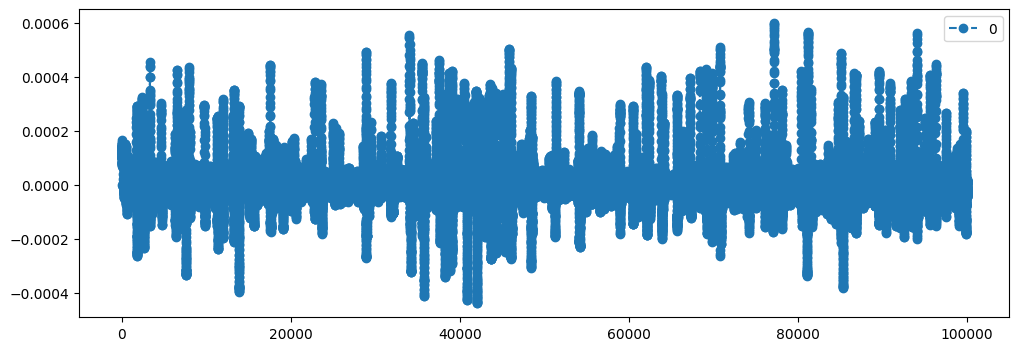

In [ ]:
df_2[0].plot(figsize=(12, 4), legend=True, linestyle="--", marker="o")

In [ ]:
#Lets use the min max scaler for this operation as the values can be negative or positive according to the position
#We keep the values between 0 and 1
#from sklearn.preprocessing import MinMaxScaler
#scaler = MinMaxScaler(feature_range=(0,1))
#for
#df_2 = scaler.fit_transform(np.array(df_2).reshape(-1, 1))

In [ ]:
#df_2 = pd.DataFrame(df_2)
#df_2

<Axes: >

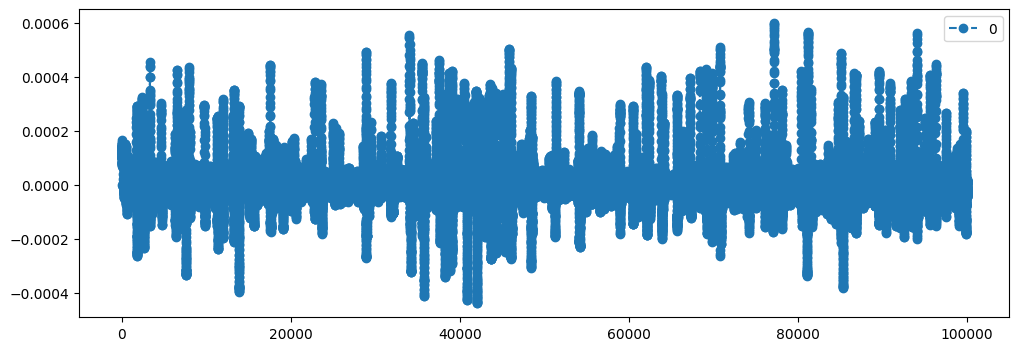

In [ ]:
df_2[0].plot(figsize=(12, 4), legend=True, linestyle="--", marker="o")

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))

In [ ]:

df_3 = pd.DataFrame()

In [ ]:
#Lets use the min max scaler for this operation as the values can be negative or positive according to the position
#We keep the values between 0 and 1
for cols in df_2:
  df_3[cols] = pd.DataFrame(scaler.fit_transform(pd.DataFrame(df_2[cols])),columns=[cols])

In [ ]:
df_3

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0.422032,0.422032,0.422032,0.422032,0.422032,0.422032,0.422032,0.422032,0.422032,0.422032,0.422032,0.422032,0.422032,0.422032,0.422032,0.422032,0.422032,0.422032,0.422032,0.422032
1,0.491924,0.491924,0.491924,0.491924,0.491924,0.491924,0.491924,0.491924,0.491924,0.491924,0.491924,0.491924,0.491924,0.491924,0.491924,0.491924,0.491924,0.491924,0.491924,0.491924
2,0.546608,0.546608,0.546608,0.546608,0.546608,0.546608,0.546608,0.546608,0.546608,0.546608,0.546608,0.546608,0.546608,0.546608,0.546608,0.546608,0.546608,0.546608,0.546608,0.546608
3,0.576952,0.576952,0.576952,0.576952,0.576952,0.576952,0.576952,0.576952,0.576952,0.576952,0.576952,0.576952,0.576952,0.576952,0.576952,0.576952,0.576952,0.576952,0.576952,0.576952
4,0.583037,0.583037,0.583037,0.583037,0.583037,0.583037,0.583037,0.583037,0.583037,0.583037,0.583037,0.583037,0.583037,0.583037,0.583037,0.583037,0.583037,0.583037,0.583037,0.583037
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,0.391075,0.391075,0.391075,0.391075,0.391075,0.391075,0.391075,0.391075,0.391075,0.391075,0.391075,0.391075,0.391075,0.391075,0.391075,0.391075,0.391075,0.391075,0.391075,0.391075
99996,0.394461,0.394461,0.394461,0.394461,0.394461,0.394461,0.394461,0.394461,0.394461,0.394461,0.394461,0.394461,0.394461,0.394461,0.394461,0.394461,0.394461,0.394461,0.394461,0.394461
99997,0.400193,0.400193,0.400193,0.400193,0.400193,0.400193,0.400193,0.400193,0.400193,0.400193,0.400193,0.400193,0.400193,0.400193,0.400193,0.400193,0.400193,0.400193,0.400193,0.400193
99998,0.405254,0.405254,0.405254,0.405254,0.405254,0.405254,0.405254,0.405254,0.405254,0.405254,0.405254,0.405254,0.405254,0.405254,0.405254,0.405254,0.405254,0.405254,0.405254,0.405254


<Axes: >

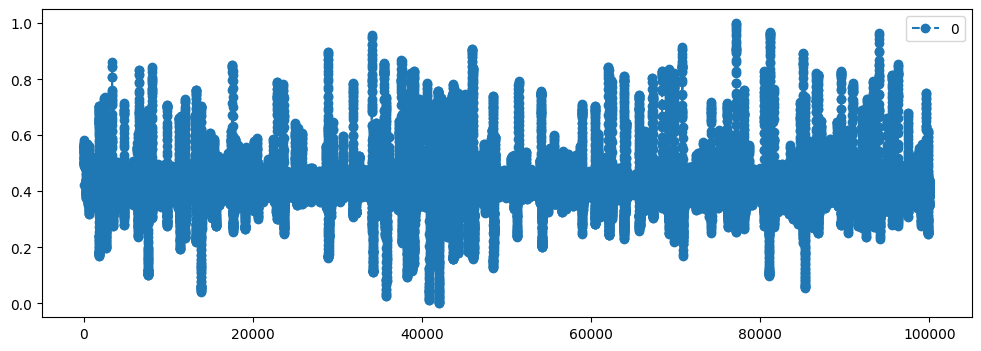

In [ ]:
df_3[0].plot(figsize=(12, 4), legend=True, linestyle="--", marker="o")

In [ ]:
len(df_3)

100000

In [ ]:
arr = df_3.to_numpy()

In [ ]:
#train_data = []
#test_data = []

In [ ]:
#We take 80% as train set for training and remaining 20% as test set for testing
train_size = int(len(arr)*0.8)
test_size = len(arr)-train_size
train_data, test_data = arr[0:train_size, :], arr[train_size:len(df_3), :1]

In [ ]:
train_data

array([[0.42203153, 0.42203153, 0.42203153, ..., 0.42203153, 0.42203153,
        0.42203153],
       [0.49192378, 0.49192378, 0.49192378, ..., 0.49192378, 0.49192378,
        0.49192378],
       [0.54660803, 0.54660803, 0.54660803, ..., 0.54660803, 0.54660803,
        0.54660803],
       ...,
       [0.42865176, 0.42865176, 0.42865176, ..., 0.42865176, 0.42865176,
        0.42865176],
       [0.42641619, 0.42641619, 0.42641619, ..., 0.42641619, 0.42641619,
        0.42641619],
       [0.42115759, 0.42115759, 0.42115759, ..., 0.42115759, 0.42115759,
        0.42115759]])

**Here, I have taken time step as 100, and we have to train the model by taking the 100 inputs to the 101 as output, and the process continues for 100000 datas. The whole model is developed in this way to predict the another time step stock close value.**

In [ ]:
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i+time_step, 0])
    return np.array(dataX), np.array(dataY)

In [ ]:
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(79899, 100)
(19899, 100)
(79899,)
(19899,)


In [ ]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [ ]:
print(X_train.shape)
print(X_test.shape)

(79899, 100, 1)
(19899, 100, 1)


**Here I have used the LSTM model, to evaluate the time-series data**

In [ ]:
#Unit Input shape can be 100
model_1 = Sequential([
    LSTM(units=100, return_sequences=True, input_shape=(100, 1)),
    Dropout(0.2),
    LSTM(100, return_sequences=True),
    Dropout(0.1),
    LSTM(50, return_sequences=True),
    Dropout(0.2),
    Flatten(),
    Dense(100, activation='relu'),
    Dropout(0.2),
    Dense(25, activation="relu"),
    Dropout(0.1),
    Dense(1)
])

In [ ]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 100)          40800     
                                                                 
 dropout (Dropout)           (None, 100, 100)          0         
                                                                 
 lstm_1 (LSTM)               (None, 100, 100)          80400     
                                                                 
 dropout_1 (Dropout)         (None, 100, 100)          0         
                                                                 
 lstm_2 (LSTM)               (None, 100, 50)           30200     
                                                                 
 dropout_2 (Dropout)         (None, 100, 50)           0         
                                                                 
 flatten (Flatten)           (None, 5000)              0

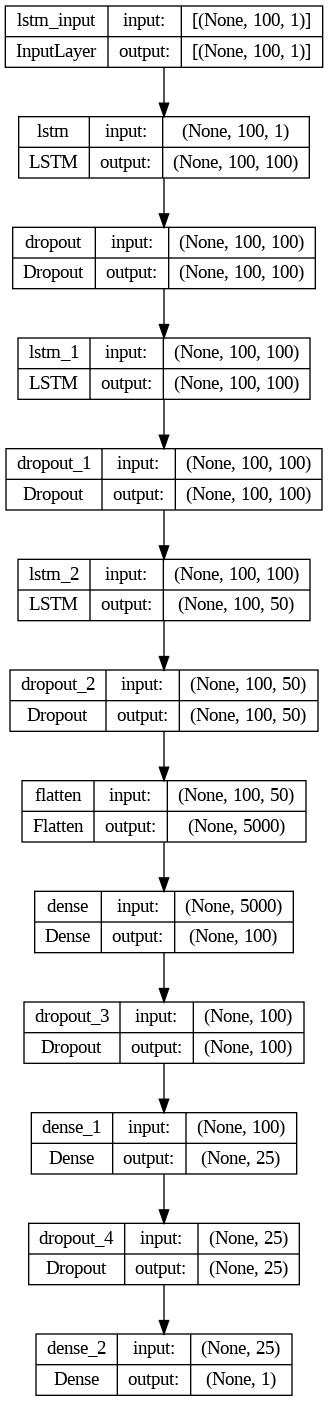

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model_1, 'model_1.jpg', show_shapes=True)

In [ ]:
model_1.compile(optimizer="adam", loss="mean_squared_error")

In [ ]:
history_1 = model_1.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10
2497/2497 [==============================] - 67s 18ms/step - loss: 0.0027 - val_loss: 5.7734e-04
Epoch 2/10
2497/2497 [==============================] - 46s 19ms/step - loss: 4.9234e-04 - val_loss: 1.6885e-04
Epoch 3/10
2497/2497 [==============================] - 72s 29ms/step - loss: 2.2857e-04 - val_loss: 5.9169e-05
Epoch 4/10
2497/2497 [==============================] - 44s 18ms/step - loss: 2.1516e-04 - val_loss: 1.0356e-04
Epoch 5/10
2497/2497 [==============================] - 46s 18ms/step - loss: 1.7748e-04 - val_loss: 9.9941e-05
Epoch 6/10
2497/2497 [==============================] - 45s 18ms/step - loss: 1.6778e-04 - val_loss: 1.1565e-04
Epoch 7/10
2497/2497 [==============================] - 58s 23ms/step - loss: 1.5546e-04 - val_loss: 1.7491e-04
Epoch 8/10
2497/2497 [==============================] - 70s 28ms/step - loss: 1.4589e-04 - val_loss: 1.6093e-04
Epoch 9/10
2497/2497 [==============================] - 73s 29ms/step - loss: 1.3388e-04 - val_loss: 6.4660e

In [ ]:
loss = model_1.evaluate(X_test, y_test)

622/622 [==============================] - 7s 12ms/step - loss: 1.8669e-04


<Axes: >

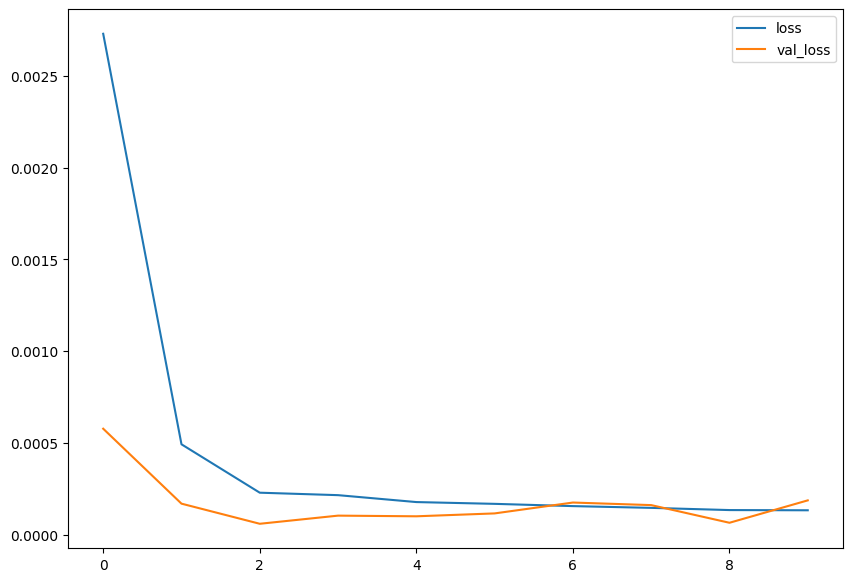

In [ ]:
pd.DataFrame(history_1.history).plot(figsize=(10, 7))

In [ ]:
test_predict_1 = model_1.predict(X_test)

622/622 [==============================] - 11s 11ms/step


In [ ]:
test_p_1 = scaler.inverse_transform(test_predict_1)

In [ ]:
y_test = y_test.reshape(19899, 1)

In [ ]:
test_p_1

array([[ 5.9138360e-06],
       [ 1.8726843e-05],
       [ 2.6974152e-05],
       ...,
       [-1.5306672e-05],
       [-1.0714783e-05],
       [-6.6288212e-06]], dtype=float32)

In [ ]:
len(test_p_1)

19899

In [ ]:
df_3[0]

0        0.422032
1        0.491924
2        0.546608
3        0.576952
4        0.583037
           ...   
99995    0.391075
99996    0.394461
99997    0.400193
99998    0.405254
99999    0.407154
Name: 0, Length: 100000, dtype: float64

In [ ]:
testPredictPlot = np.empty_like(test_p_1)
len(testPredictPlot)

19899

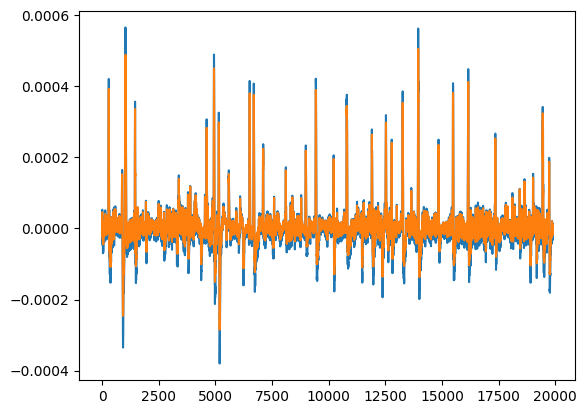

In [ ]:

back = 100

testPredictPlot = np.empty_like(test_p_1)

testPredictPlot[:len(test_p_1)+back, :] = test_p_1


plt.plot(scaler.inverse_transform(y_test))
plt.plot(testPredictPlot)
plt.show()

# So this is how we are able to plot the FP1-F7, and we could do the same for all the other graph plots and evaluate our whole signal